## Dados Textuais: classificação e exploração.

In [ ]:
import pandas as pd

resenha = pd.read_csv("dados/imdb-reviews-pt-br.csv")
resenha.head()

In [ ]:
print(resenha.sentiment.value_counts())

In [ ]:
classificacao = resenha["sentiment"].replace(["neg", "pos"], [0,1])
resenha["classificacao"] = classificacao
resenha.head()

## Bag of Words: criando representações da linguagem humana.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

vetorizar = CountVectorizer(lowercase=False, max_features=50)
exemplo_texto = ['texto maluco TExto', 'muito maluco mais ou menos bom', 'texto muito bom', 'texto muito ruim']
bag_of_words = vetorizar.fit_transform(exemplo_texto)
print(vetorizar.get_feature_names())
print(bag_of_words.shape)
print(bag_of_words)

['TExto', 'bom', 'mais', 'maluco', 'menos', 'muito', 'ou', 'ruim', 'texto']
(4, 9)
  (0, 8)	1
  (0, 3)	1
  (0, 0)	1
  (1, 3)	1
  (1, 5)	1
  (1, 2)	1
  (1, 6)	1
  (1, 4)	1
  (1, 1)	1
  (2, 8)	1
  (2, 5)	1
  (2, 1)	1
  (3, 8)	1
  (3, 5)	1
  (3, 7)	1


In [30]:
def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(texto[coluna_texto])

    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                              texto[coluna_classificacao],
                                                              random_state = 42)

    regressao_logistica = LogisticRegression(solver = "lbfgs")
    regressao_logistica.fit(treino, classe_treino)

    return regressao_logistica.score(teste, classe_teste)


res = classificar_texto(resenha, "text_pt", "classificacao")
print(res)

0.6583097452486858


## Visualizando os dados com WordCloud.

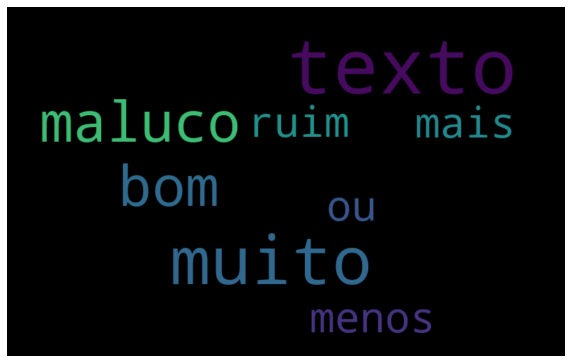

In [35]:
# conda install -c conda-forge wordcloud
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

exemplo_texto = ['texto maluco TExto', 'muito maluco mais ou menos bom', 'texto muito bom', 'texto muito ruim']
todas_palavras = ' '.join([texto for texto in exemplo_texto])
# todas_palavras = ' '.join([texto for texto in resenha.text_pt])

nuvem_palavras = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(todas_palavras)

plt.figure(figsize=(10,7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis("off")
plt.show()

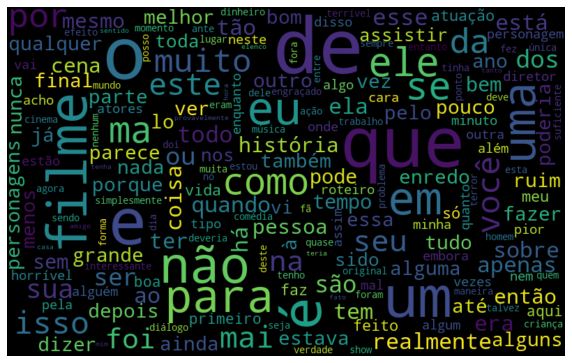

In [38]:
def nuvem_palavras_neg(texto, coluna_texto):
    texto_negativo = texto.query("sentiment == 'neg'")
    todas_palavras = ' '.join([texto for texto in texto_negativo[coluna_texto]])

    nuvem_palavras = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

nuvem_palavras_neg(resenha, "text_pt")

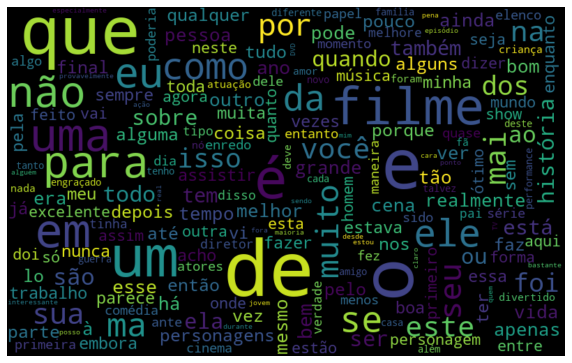

In [39]:
def nuvem_palavras_pos(texto, coluna_texto):
    texto_positivo = texto.query("sentiment == 'pos'")
    todas_palavras = ' '.join([texto for texto in texto_positivo[coluna_texto]])

    nuvem_palavras = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

nuvem_palavras_pos(resenha, "text_pt")

## Tokenização e a bliblioteca NLTK.

In [41]:
import nltk 
frase = ["um filme bom", "um filme ruim"]
frequencia = nltk.FreqDist(frase)
frequencia

FreqDist({'um filme bom': 1, 'um filme ruim': 1})

In [42]:
from nltk import tokenize

frase = "Bem vindo ao mundo do PLN!"

token_espaco = tokenize.WhitespaceTokenizer()
token_frase = token_espaco.tokenize(frase)
print(token_frase)

['Bem', 'vindo', 'ao', 'mundo', 'do', 'PLN!']


In [44]:
token_frase = token_espaco.tokenize(todas_palavras)
frequencia = nltk.FreqDist(token_frase)
df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                   "Frequência": list(frequencia.values())})

In [45]:
df_frequencia.nlargest(columns = "Frequência", n = 10)

,Palavra,Frequência
0,texto,3
3,muito,3
1,maluco,2
7,bom,2
2,TExto,1
4,mais,1
5,ou,1
6,menos,1
8,ruim,1


## Uma nova visualização e os stop words.

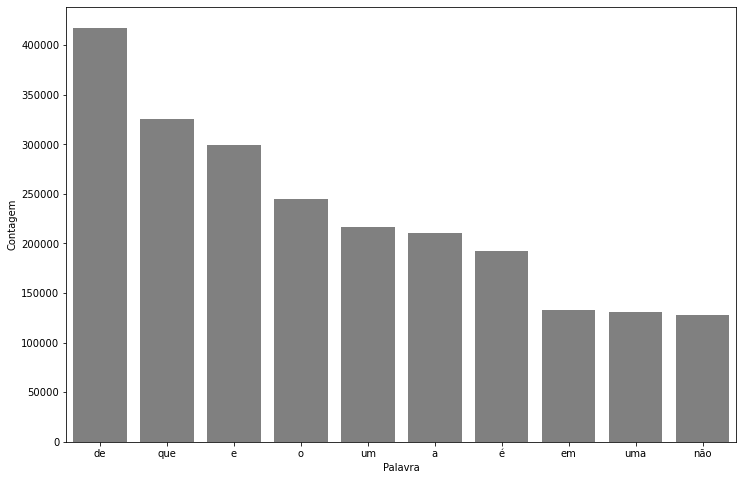

In [47]:
import seaborn as sns

def pareto(texto, coluna_texto, quantidade):
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    token_frase = token_espaco.tokenize(todas_palavras)
    frequencia = nltk.FreqDist(token_frase)
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                   "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = quantidade)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x = "Palavra", y = "Frequência", color = 'gray')
    ax.set(ylabel = "Contagem")
    plt.show()

pareto(resenha, "text_pt", 10)

In [50]:
import nltk
# nltk.download('all') # --> muito demorado
# nltk.download('portuguese') # --> mais rapido

palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")

frase_processada = list()
for opiniao in resenha.text_pt:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in palavras_irrelevantes:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
resenha["tratamento_1"] = frase_processada
# resenha.head()

,id,text_en,text_pt,sentiment,classificacao,tratamento_1
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão palavra apropriada eles, ve..."


In [ ]:
classificar_texto(resenha, "tratamento_1", "classificacao")

In [ ]:
pareto(resenha,"tratamento_1", 10)